In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import cv2
import numpy as np

In [6]:
from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')

In [7]:
import sys
sys.path.append('../')

In [182]:
from depth_Functions import import_raw_colour_image, show_img, show_array_of_images

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) we need to get the feature vector of a patch.

We obtain a vector of length 34. A standard and squared version of:

1. 9 texture variations:
    - Each texture variation is obtained using one of the 9 Laws' masks of the intensity
1. 2 Haze variations:
    - 1st Laws' mask applied to the red difference and blue difference
1. 6 texture gradients:
    - Edge detection at angle intervals of $30^\circ$

# Image

## BGR

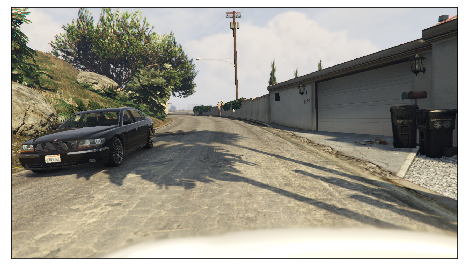

In [10]:
bgr_0 = import_raw_colour_image(list(colour.iterdir())[0])
show_img(bgr_0)

## YCbCR

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

In [11]:
ycc_0 = cv2.cvtColor(bgr_0, cv2.COLOR_BGR2YCrCb) 

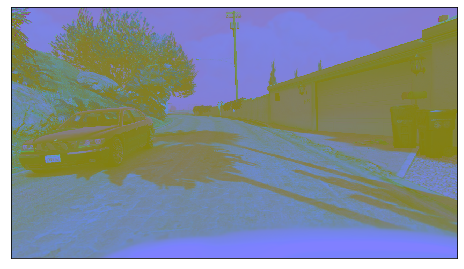

In [12]:
show_img(ycc_0)

As we'll be carrying out different implementations on each channel, we'll separate them into different arrays

In [13]:
y, cr, cb = cv2.split(ycc_0)

# Laws' Mask 

[Based on](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

In [14]:
filters = [
                np.array([ 1,  4,  6,  4,  1]),
                np.array([-1, -2,  0,  2,  1]),
                np.array([-1,  0,  2,  0, -1]),
                np.array([ 1, -4,  6, -4,  1])
               ] 
def mask(patch, first, second=None):
    
    
    if second is None:
        return cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(patch, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

def texture_variation(patch_intensity):
    level, edge, spot, ripple = 0, 1, 2, 3
    
    masks = [
                mask(patch_intensity, level, edge),
                mask(patch_intensity, level, ripple),
                mask(patch_intensity, edge, spot),
                mask(patch_intensity, spot),
                mask(patch_intensity, ripple),
                mask(patch_intensity, level, spot),
                mask(patch_intensity, edge),
                mask(patch_intensity, edge, ripple),
                mask(patch_intensity, spot, ripple),
             ]
    
    return masks

def haze(cr, cb):
    
    return [mask(cr, 0, 1), mask(cb, 0, 1)]

In [15]:
laws = texture_variation(y) + haze(cr, cb)

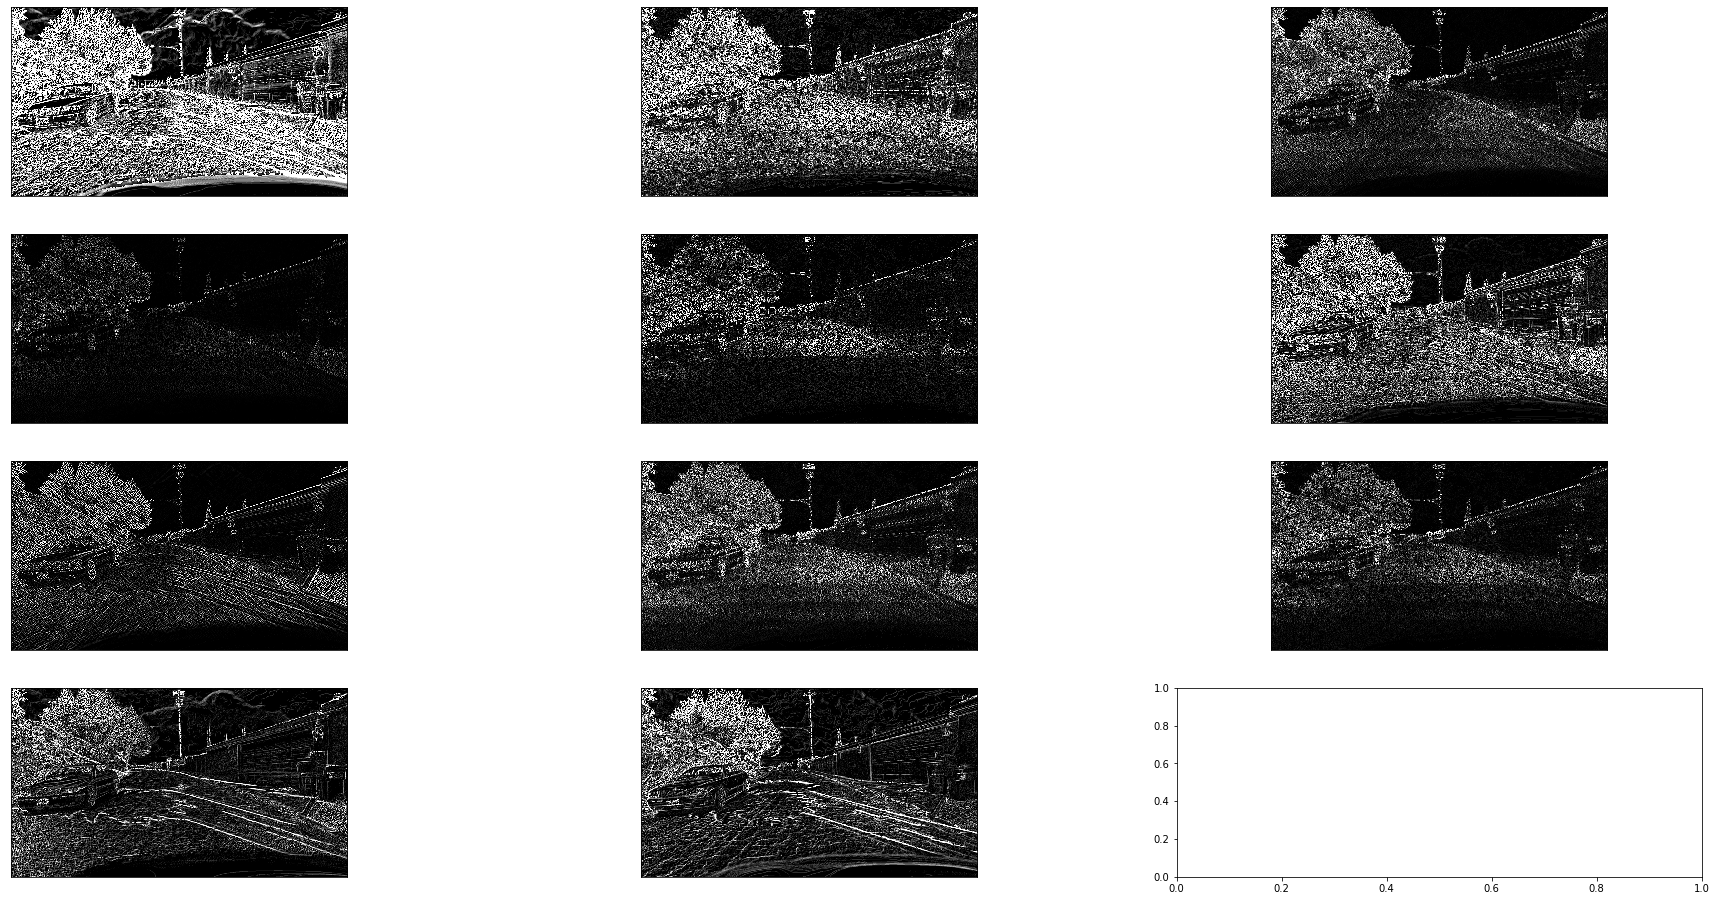

In [185]:
show_array_of_images(laws, figsize=(16,32))

# Edge detection

The angle the edge detector registers the change in gradient is determined by the kernel.

In [172]:
import math

def create_kernels(step=90, min=0, max=180):
    kernels = []
    
    for angle in range(min,max,step):
        rad = math.radians(angle)
        cos = round(math.cos(rad),2)
        sin = round(math.sin(rad),2)
        kernels.append(np.array([
                                    [sin-cos,   2*sin, cos+sin],
                                    [-2*cos,        0,   2*cos],
                                    [-sin-cos, -2*sin, cos-sin] 
                                ]))
    
    return kernels

[OpenCV canny edge detection](https://github.com/opencv/opencv/blob/master/modules/imgproc/src/canny.cpp) is predetermined to combine vertical and horizontal edge detection with no means to input custom kernels. So use our own implementation, [based on a tutorial by towards datascience](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).

In [173]:
from scipy import ndimage

def denoise(patch, size=5, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g_kernel =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return ndimage.filters.convolve(patch, g_kernel)

def texture_gradients(patch, *args, **kwargs):
    kernels = create_kernels(*args, **kwargs)
    gausian = denoise(patch)
    gradients = []
    
    for kernel in kernels:
        gradients.append(ndimage.filters.convolve(patch, kernel))
        
    return gradients
    
# For if we implement thresholds:
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def get_thresholds(patch, sigma=0.33):
    v = np.median(patch)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 - sigma) * v))

In [175]:
edges = texture_gradients(y, step=30)

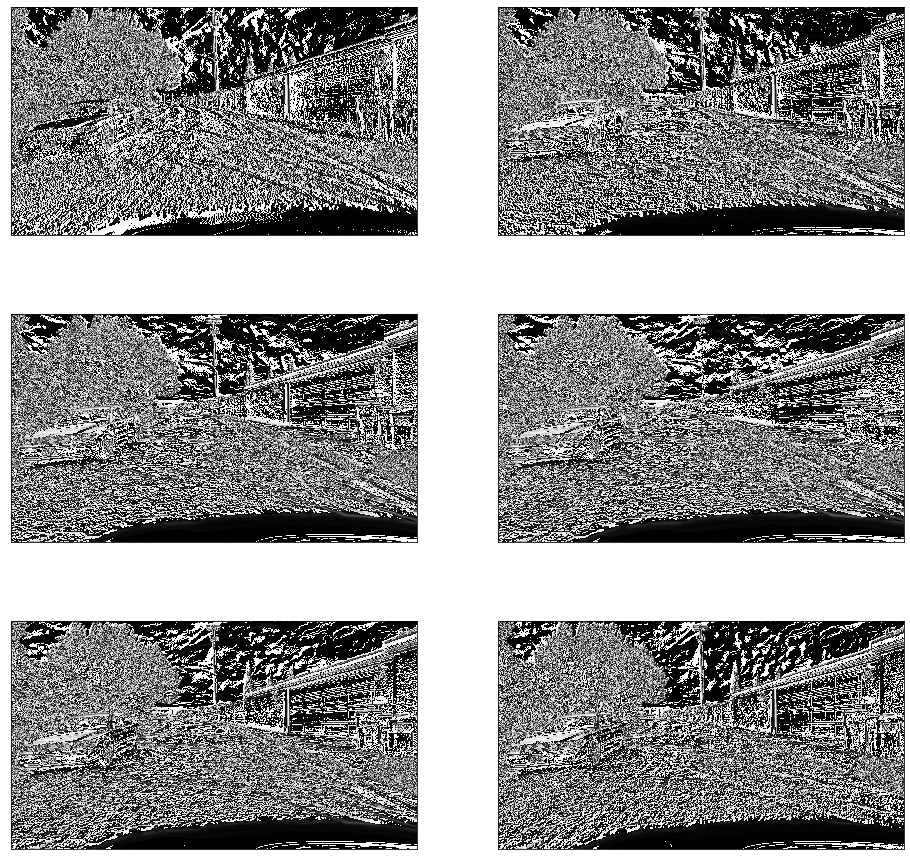

In [179]:
show_array_of_images(edges)

In [180]:
def create_feature_vector(patch):
    vector = []
    y, cr, cb = cv2.split(cv2.cvtColor(patch, cv2.COLOR_BGR2YCrCb))
    
    vector = texture_variation(y) 
    vector += haze(cr, cb)
    vector += texture_gradients(y, step=30)
    vector += [feature**2 for feature in vector]
    return [np.sum(feature) for feature in vector]

In [181]:
Features = create_feature_vector(bgr_0)
Features

[49125363.0,
 33189977.5,
 15115827.0,
 9659869,
 23365946,
 29414407.0,
 28961593,
 17890578.0,
 11915700.5,
 19299598.5,
 21838039.5,
 97962048,
 94038488,
 95243033,
 97456440,
 94643554,
 93143469,
 5229052926.5,
 3114563007.75,
 969879118.5,
 26399195,
 36850990,
 2696630608.5,
 31785881,
 1284072417.5,
 707280441.75,
 1342209460.75,
 1603460661.75,
 57560486,
 60919786,
 65216761,
 66876694,
 65755142,
 62256633]

# Separating the image into patches

In [336]:
np.zeros(len(create_feature_vector(bgr_0[0:1,0:1])))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [402]:
shape = bgr_0.shape
shape + (0,)

(720, 1280, 3, 0)

In [63]:
from tqdm.notebook import tqdm

def process_patches(image, patchsize, function=lambda x: x, stride=None):
    if stride is None:
        stride = patchsize
    
    vector = function(image)
    shape = image.shape[:2]
    shape += (len(vector),) if isinstance(vector, list) else ()
    
    patches = np.zeros(shape)
    heights = [y for y in range(0, image.shape[0]+1, stride[0])]
    widths = [x for x in range(0, image.shape[1]+1, stride[1])]
    
    for y_0, y_1 in tqdm(zip(heights, heights[1:]), 
                         total=len(heights)-1, leave=False):
        for x_0, x_1 in zip(widths, widths[1:]):
            patches[y_0:y_1, x_0:x_1] = np.array(function(image[y_0:y_1, x_0:x_1]))
    
    return np.array(patches)

def nxm_patches(image, nxm, *args, **kwargs):
    height = int(image.shape[0] / nxm[0])
    width = int(image.shape[1] / nxm[1])
    
    return process_patches(image, (height, width), *args, **kwargs)

In [64]:
patch_360x640 = nxm_patches(bgr_0, (2,2), function=create_feature_vector)

NameError: name 'create_feature_vector' is not defined

In [405]:
patch_360x640.shape

(720, 1280, 34)

In [61]:
show_img(patch_360x640[:,:,0])

NameError: name 'patch_360x640' is not defined

In [37]:
patch_6x6 = process_patches(bgr_0, (6,6), function=create_feature_vector)

NameError: name 'process_patches' is not defined

In [408]:
patch_6x6.shape

(720, 1280, 34)

In [36]:
show_img(patch_6x6[:,:,0], colour=False)

NameError: name 'patch_6x6' is not defined